In [31]:
# =================================================================================
# SECTION 1: PROJECT SCAFFOLDING & CONFIGURATION (BASELINE)
# =================================================================================

# ---------------------------------------------------------------------------------
# 1.1: IMPORTS
# ---------------------------------------------------------------------------------
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTConfig
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import copy

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ---------------------------------------------------------------------------------
# 1.2: CONFIGURATION CLASS
# ---------------------------------------------------------------------------------
class Config:
    # --- Data Paths and Domains ---
    DATA_DIR = r"D:\Haseeb\Datasets\VLCS" # Make sure this path is correct for your dataset
    DOMAINS = ["Caltech101", "LabelMe", "SUN09", "VOC2007"]
    
    # --- Model & Architecture ---
    MODEL_NAME = "WinKawaks/vit-tiny-patch16-224"
    NUM_CLASSES = 5
    ### CHANGE ###
    NUM_HEADS = 1 # A baseline model has only one classification head.
    DROPOUT_RATE = 0.5
    
    # --- Training Hyperparameters ---
    BATCH_SIZE = 128
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-4
    OPTIMIZER = "AdamW"
    
    # --- Hardware & Reproducibility ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42

# Instantiate the config
config = Config()

# Print out the configuration to verify
print("--- Project Configuration (BASELINE) ---")
for key, value in config.__class__.__dict__.items():
    if not key.startswith('__'):
        print(f"{key}: {value}")
print("--------------------------------------")
print(f"Device: {config.DEVICE}")

# ---------------------------------------------------------------------------------
# 1.3: RESULTS TRACKER
# ---------------------------------------------------------------------------------
experiment_results = []

print("\nProject scaffolding is complete. Ready for Section 2.")

--- Project Configuration (BASELINE) ---
DATA_DIR: D:\Haseeb\Datasets\VLCS
DOMAINS: ['Caltech101', 'LabelMe', 'SUN09', 'VOC2007']
MODEL_NAME: WinKawaks/vit-tiny-patch16-224
NUM_CLASSES: 5
NUM_HEADS: 1
DROPOUT_RATE: 0.5
BATCH_SIZE: 128
NUM_EPOCHS: 5
LEARNING_RATE: 0.0001
OPTIMIZER: AdamW
DEVICE: cuda
SEED: 42
--------------------------------------
Device: cuda

Project scaffolding is complete. Ready for Section 2.


In [32]:
# =================================================================================
# SECTION 2: DATA LOADING & PREPROCESSING (BASELINE)
# =================================================================================
# (This section is identical to the previous notebook)

# ---------------------------------------------------------------------------------
# 2.1: IMAGE TRANSFORMATIONS
# ---------------------------------------------------------------------------------
IMG_SIZE = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}

# =================================================================================
# SECTION 2.2: CUSTOM VLCS DATASET CLASS (ROBUST "REPLACE WITH RANDOM")
# =================================================================================
# Replace the old Dataset class in Section 2 with this new version.

import random # Make sure to import the 'random' library at the top of the cell.

### CHANGE 1: Renamed the class to VLCSDataset ###
class VLCSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.domains = domains
        self.transform = transform
        self.image_paths = []
        self.labels = []
        ### CHANGE 2: Add a counter for corrupted images ###
        self.corrupted_images_count = 0
        
        try:
            self.classes = sorted(os.listdir(os.path.join(root_dir, domains[0])))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        except FileNotFoundError:
            print(f"Error: Could not find domain folder at {os.path.join(root_dir, domains[0])}")
            print("Please ensure your DATA_DIR and DOMAINS in the Config class are correct.")
            raise

        for domain in self.domains:
            domain_path = os.path.join(self.root_dir, domain)
            for class_name in self.classes:
                class_path = os.path.join(domain_path, class_name)
                if os.path.isdir(class_path):
                    for img_name in os.listdir(class_path):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
        except (OSError, IOError) as e:
            ### CHANGE 3: Increment the counter and replace with a random image ###
            self.corrupted_images_count += 1
            # You can uncomment the print statement below for verbose debugging if you want
            # print(f"Warning: Corrupted image at {img_path}. Replacing with random. Total corrupt: {self.corrupted_images_count}")
            
            # Pick a new random index
            new_idx = random.randint(0, len(self) - 1)
            # Recursively call __getitem__ with the new index.
            return self.__getitem__(new_idx)

        # The transformation part remains the same
        if self.transform:
            image = self.transform(image)
            
        return image, label

# =================================================================================
# SECTION 2.3: DATALOADER HELPER FUNCTION (NEW 80/20 SPLIT VERSION)
# =================================================================================
# Replace the old get_dataloaders function in Section 2 of BOTH notebooks with this.

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def get_dataloaders(root_dir, target_domain, all_domains, batch_size, seed):
    """
    Creates dataloaders for a LODO split using an 80/20 split on the source domains.
    """
    source_domains = [d for d in all_domains if d != target_domain]
    
    print(f"--- Creating DataLoaders (80/20 Split Strategy) ---")
    print(f"Target (Test) Domain: {target_domain}")
    print(f"Source Domains for Train/Val: {source_domains}")
    
    # 1. Create a single, large dataset by combining all source domains
    source_dataset = VLCSDataset(
        root_dir=root_dir, 
        domains=source_domains, 
        transform=data_transforms['train'] # Use training transforms for the whole source
    )
    
    # We need to perform a stratified split to ensure the train and val sets
    # have a similar distribution of classes.
    indices = list(range(len(source_dataset)))
    labels = source_dataset.labels
    
    # Use sklearn's train_test_split to get indices for an 80% train / 20% val split
    train_idx, val_idx = train_test_split(
        indices, 
        test_size=0.2, 
        stratify=labels, 
        random_state=seed
    )
    
    # 2. Create the training and validation subsets
    train_subset = Subset(source_dataset, train_idx)
    val_subset = Subset(source_dataset, val_idx)
    
    # Important: The validation subset should not use training augmentations (like RandomFlip).
    # We create a new dataset object for validation with the correct transforms.
    # This is a cleaner way to handle transforms for subsets.
    val_dataset_clean = VLCSDataset(root_dir=root_dir, domains=source_domains, transform=data_transforms['val'])
    val_subset_final = Subset(val_dataset_clean, val_idx)
    
    # 3. Create the test dataset from the full target domain
    test_dataset = VLCSDataset(
        root_dir=root_dir, 
        domains=[target_domain], 
        transform=data_transforms['val']
    )

    # 4. Create the DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset_final, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"Source data size: {len(source_dataset)}")
    print(f"  -> Training on: {len(train_subset)} images (80%)")
    print(f"  -> Validating on: {len(val_subset_final)} images (20%)")
    print(f"Testing on full '{target_domain}' domain: {len(test_dataset)} images")
    print("----------------------------------------------------")
    
    return train_loader, val_loader, test_loader

In [33]:
# =================================================================================
# SECTION 3: THE MODEL ARCHITECTURE (BASELINE)
# =================================================================================

### CHANGE ###
# Renamed to BaselineViT and simplified for a single head.

class BaselineViT(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rate):
        super(BaselineViT, self).__init__()
        
        self.vit_backbone = ViTModel.from_pretrained(model_name)
        hidden_dim = self.vit_backbone.config.hidden_size
        
        ### CHANGE ###
        # We only create a single head now, not a ModuleList.
        self.head = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, images):
        outputs = self.vit_backbone(pixel_values=images)
        feature_vector_z = outputs.last_hidden_state[:, 0, :]
        
        ### CHANGE ###
        # The forward pass is simpler: just pass through the single head
        # and return the final logits tensor directly.
        logits = self.head(feature_vector_z)
        return logits

In [34]:
# =================================================================================
# SECTION 4: TRAINING & EVALUATION LOGIC (BASELINE)
# =================================================================================

### CHANGE ###
# This is now a standard, simple training loop. No competition, no winner selection.

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc="Training Epoch", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return {"avg_train_loss": avg_loss}


### CHANGE ###
# The evaluation function is simplified. No ensembling is needed.

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            total_samples += labels.size(0)

            # Forward pass
            logits = model(images)
            
            # Calculate loss
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Calculate accuracy
            _, preds = torch.max(logits, 1)
            correct_preds += torch.sum(preds == labels).item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_preds / total_samples
    
    return {"avg_loss": avg_loss, "accuracy": accuracy}

In [35]:
# =================================================================================
# SECTION 5: THE MAIN EXPERIMENT LOOP (BASELINE)
# =================================================================================

config = Config()

for target_domain in config.DOMAINS:
    print(f"==============================================================")
    print(f"  STARTING LODO EXPERIMENT: Target Domain = {target_domain.upper()}")
    print(f"==============================================================")
    
    train_loader, val_loader, test_loader = get_dataloaders(
        root_dir=config.DATA_DIR,
        target_domain=target_domain,
        all_domains=config.DOMAINS,
        batch_size=config.BATCH_SIZE, seed=config.SEED
    )
    
    ### CHANGE ###
    # Instantiate the BaselineViT model.
    model = BaselineViT(
        model_name=config.MODEL_NAME,
        num_classes=config.NUM_CLASSES,
        dropout_rate=config.DROPOUT_RATE
    ).to(config.DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    best_val_accuracy = 0.0
    best_model_state = None
    
    for epoch in range(config.NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{config.NUM_EPOCHS} ---")
        
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, config.DEVICE)
        val_metrics = evaluate(model, val_loader, criterion, config.DEVICE)
        
        ### CHANGE ###
        # Update the logging to match the new return values from train_one_epoch.
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_metrics['avg_train_loss']:.4f}")
        print(f"  Validation Loss: {val_metrics['avg_loss']:.4f}")
        print(f"  Validation Accuracy: {val_metrics['accuracy']:.4f}")
        
        if val_metrics['accuracy'] > best_val_accuracy:
            print(f"  New best validation accuracy! Saving model state.")
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = copy.deepcopy(model.state_dict())
            
    print("\nTraining complete for this LODO split.")
    print("Loading best model state and evaluating on the TEST set...")
    
    model.load_state_dict(best_model_state)
    test_metrics = evaluate(model, test_loader, criterion, config.DEVICE)
    
    print(f"\n--- RESULTS FOR TARGET DOMAIN: {target_domain.upper()} ---")
    print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"--------------------------------------------------")

    experiment_results.append({
        "target_domain": target_domain,
        "source_domains": [d for d in config.DOMAINS if d != target_domain],
        "test_accuracy": test_metrics['accuracy'],
        "best_val_accuracy": best_val_accuracy,
        "model_name": config.MODEL_NAME,
        "num_epochs": config.NUM_EPOCHS,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE
    })

print("\n\n==============================================================")
print("          ALL BASELINE LODO EXPERIMENTS COMPLETE")
print("==============================================================")

  STARTING LODO EXPERIMENT: Target Domain = CALTECH101
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: Caltech101
Source Domains for Train/Val: ['LabelMe', 'SUN09', 'VOC2007']
Source data size: 9314
  -> Training on: 7451 images (80%)
  -> Validating on: 1863 images (20%)
Testing on full 'Caltech101' domain: 1415 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Loss: 1.0712
  Validation Loss: 0.5773
  Validation Accuracy: 0.7933
  New best validation accuracy! Saving model state.

--- Epoch 2/5 ---


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Loss: 0.5434
  Validation Loss: 0.5093
  Validation Accuracy: 0.8213
  New best validation accuracy! Saving model state.

--- Epoch 3/5 ---


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Loss: 0.4155
  Validation Loss: 0.5400
  Validation Accuracy: 0.8175

--- Epoch 4/5 ---


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Loss: 0.3049
  Validation Loss: 0.5589
  Validation Accuracy: 0.8148

--- Epoch 5/5 ---


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Loss: 0.2301
  Validation Loss: 0.6538
  Validation Accuracy: 0.8154

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: CALTECH101 ---
  Test Accuracy: 0.9795
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = LABELME
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: LabelMe
Source Domains for Train/Val: ['Caltech101', 'SUN09', 'VOC2007']
Source data size: 8073
  -> Training on: 6458 images (80%)
  -> Validating on: 1615 images (20%)
Testing on full 'LabelMe' domain: 2656 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Loss: 1.0157
  Validation Loss: 0.3939
  Validation Accuracy: 0.8502
  New best validation accuracy! Saving model state.

--- Epoch 2/5 ---


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Loss: 0.3848
  Validation Loss: 0.4767
  Validation Accuracy: 0.8477

--- Epoch 3/5 ---


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Loss: 0.2639
  Validation Loss: 0.4033
  Validation Accuracy: 0.8693
  New best validation accuracy! Saving model state.

--- Epoch 4/5 ---


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Loss: 0.1588
  Validation Loss: 0.4328
  Validation Accuracy: 0.8724
  New best validation accuracy! Saving model state.

--- Epoch 5/5 ---


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Loss: 0.1032
  Validation Loss: 0.4707
  Validation Accuracy: 0.8762
  New best validation accuracy! Saving model state.

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: LABELME ---
  Test Accuracy: 0.6770
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = SUN09
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: SUN09
Source Domains for Train/Val: ['Caltech101', 'LabelMe', 'VOC2007']
Source data size: 7447
  -> Training on: 5957 images (80%)
  -> Validating on: 1490 images (20%)
Testing on full 'SUN09' domain: 3282 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Loss: 0.9757
  Validation Loss: 0.4858
  Validation Accuracy: 0.8154
  New best validation accuracy! Saving model state.

--- Epoch 2/5 ---


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Loss: 0.4389
  Validation Loss: 0.4327
  Validation Accuracy: 0.8403
  New best validation accuracy! Saving model state.

--- Epoch 3/5 ---


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Loss: 0.3258
  Validation Loss: 0.4598
  Validation Accuracy: 0.8463
  New best validation accuracy! Saving model state.

--- Epoch 4/5 ---


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Loss: 0.2384
  Validation Loss: 0.4814
  Validation Accuracy: 0.8557
  New best validation accuracy! Saving model state.

--- Epoch 5/5 ---


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Loss: 0.1681
  Validation Loss: 0.5823
  Validation Accuracy: 0.8356

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: SUN09 ---
  Test Accuracy: 0.7693
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = VOC2007
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: VOC2007
Source Domains for Train/Val: ['Caltech101', 'LabelMe', 'SUN09']
Source data size: 7353
  -> Training on: 5882 images (80%)
  -> Validating on: 1471 images (20%)
Testing on full 'VOC2007' domain: 3376 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Loss: 0.9087
  Validation Loss: 0.4747
  Validation Accuracy: 0.8239
  New best validation accuracy! Saving model state.

--- Epoch 2/5 ---


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Loss: 0.4744
  Validation Loss: 0.5355
  Validation Accuracy: 0.7967

--- Epoch 3/5 ---


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Loss: 0.3737
  Validation Loss: 0.4626
  Validation Accuracy: 0.8314
  New best validation accuracy! Saving model state.

--- Epoch 4/5 ---


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Loss: 0.2637
  Validation Loss: 0.5210
  Validation Accuracy: 0.8280

--- Epoch 5/5 ---


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Loss: 0.1802
  Validation Loss: 0.9300
  Validation Accuracy: 0.7886

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: VOC2007 ---
  Test Accuracy: 0.7725
--------------------------------------------------


          ALL BASELINE LODO EXPERIMENTS COMPLETE


--- Final Experiment Results ---
  target_domain  test_accuracy  best_val_accuracy  num_epochs  batch_size  learning_rate                      model_name
0    Caltech101       0.979505           0.821256           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
1       LabelMe       0.676958           0.876161           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
2         SUN09       0.769348           0.855705           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
3       VOC2007       0.772512           0.831407           5         128         0.0001  WinKawaks/vit-tiny-patch16-224

Average Test Accuracy Across All Domains: 0.7996


C:\Users\Haseeb\AppData\Local\Temp\ipykernel_35248\2340688840.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


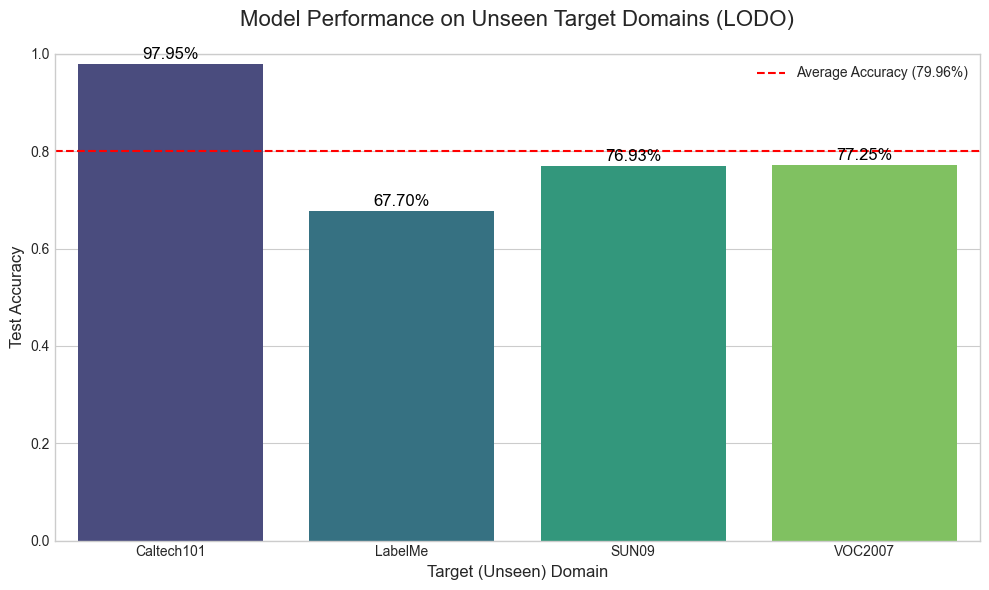


--- Dictionary for Final Plotting ---
# Copy the dictionary below and paste it into your final analysis notebook.
my_method_results = {
    'target_domain': ['Caltech101', 'LabelMe', 'SUN09', 'VOC2007'],
    'test_accuracy': [0.9795, 0.677, 0.7693, 0.7725]
}

--- Experiment Complete ---


In [35]:
# =================================================================================
# SECTION 6: ANALYSIS & VISUALIZATION (with Dictionary Output)
# =================================================================================
# Now that all experiments are complete, we'll process the results
# and create visualizations to understand the performance of our method.
# ---------------------------------------------------------------------------------

# Add this magic command to ensure plots are displayed in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------------------------------------------------------------------
# 6.1: DISPLAY RESULTS IN A TABLE
# ---------------------------------------------------------------------------------
print("--- Final Experiment Results ---")

results_df = pd.DataFrame(experiment_results)
column_order = [
    "target_domain", "test_accuracy", "best_val_accuracy", "num_epochs",
    "batch_size", "learning_rate", "model_name"
]
existing_columns = [col for col in column_order if col in results_df.columns]
results_df = results_df[existing_columns]
average_accuracy = results_df['test_accuracy'].mean()

print(results_df.to_string())
print("\n" + "="*50)
print(f"Average Test Accuracy Across All Domains: {average_accuracy:.4f}")
print("="*50)


# ---------------------------------------------------------------------------------
# 6.2: VISUALIZE THE RESULTS
# ---------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(
    data=results_df, x='target_domain', y='test_accuracy', ax=ax, palette='viridis'
)

for index, row in results_df.iterrows():
    ax.text(index, row['test_accuracy'] + 0.01, f"{row['test_accuracy']:.2%}",
            color='black', ha="center", fontsize=12)
    
ax.axhline(average_accuracy, ls='--', color='red', label=f'Average Accuracy ({average_accuracy:.2%})')

ax.set_title('Model Performance on Unseen Target Domains (LODO)', fontsize=16, pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
### NEW SECTION ###
# 6.3: GENERATE COPY-PASTE DICTIONARY FOR FINAL PLOTTING
# ---------------------------------------------------------------------------------
print("\n" + "="*70)
print("--- Dictionary for Final Plotting ---")
print("# Copy the dictionary below and paste it into your final analysis notebook.")

# Determine the variable name based on the notebook (you can adjust this)
# For the baseline notebook, you'd want 'baseline_results'.
# For the evolutionary notebook, you'd want 'evolutionary_results'.
method_name = "my_method_results" # Generic name
if "baseline" in os.getcwd(): # Simple check if 'baseline' is in the notebook path
    method_name = "baseline_results"
elif "drop-out" in os.getcwd():
    method_name = "evolutionary_results"
    
# Extract the lists from the DataFrame
domain_list = results_df['target_domain'].tolist()
accuracy_list = [round(acc, 4) for acc in results_df['test_accuracy'].tolist()]

# Print in the desired format
print(f"{method_name} = {{")
print(f"    'target_domain': {domain_list},")
print(f"    'test_accuracy': {accuracy_list}")
print(f"}}")
print("="*70)


print("\n--- Experiment Complete ---")